In [7]:
import os
from glob import glob
import numpy as np
import torch
import torch.utils.data
from PIL import Image
from torchvision import transforms
import tifffile
import re
import matplotlib.pyplot as plt

class Dataset_maker(torch.utils.data.Dataset):
    def __init__(self, root, category, config, is_train=True):
        self.image_transform = transforms.Compose(
            [
                transforms.Resize((config.data.image_size, config.data.image_size)),
                transforms.ToTensor(),  # Scales data into [0,1]
                transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
            ]
        )
        self.depth_transform = transforms.Compose(
            [
                transforms.Resize((config.data.image_size, config.data.image_size)),
                transforms.ToTensor(),  # Scales data into [0,1]
            ]
        )
        self.config = config
        self.mask_transform = transforms.Compose(
            [
                transforms.Resize((config.data.image_size, config.data.image_size)),
                transforms.ToTensor(),  # Scales data into [0,1]
            ]
        )

        if is_train:
            if category:
                self.image_files = sorted(glob(os.path.join(root, category, "train", "good", "rgb", "*.png")))
                self.depth_files = sorted(glob(os.path.join(root, category, "train", "good", "xyz", "*.tiff")))
            else:
                self.image_files = sorted(glob(os.path.join(root, "train", "good", "rgb", "*.png")))
                self.depth_files = sorted(glob(os.path.join(root, "train", "good", "xyz", "*.tiff")))
        else:
            if category:
                self.image_files = sorted(glob(os.path.join(root, category, "test", "*", "rgb", "*.png")))
                self.depth_files = sorted(glob(os.path.join(root, category, "test", "*", "xyz", "*.tiff")))
            else:
                self.image_files = sorted(glob(os.path.join(root, "test", "*", "rgb", "*.png")))
                self.depth_files = sorted(glob(os.path.join(root, "test", "*", "xyz", "*.tiff")))

        print(f"Found {len(self.image_files)} RGB images")
        print(f"Found {len(self.depth_files)} Depth images")

        self.is_train = is_train

        # Ensure alignment of image and depth files by their numeric identifiers
        self.image_files.sort(key=lambda f: int(re.findall(r'\d+', os.path.basename(f))[0]))
        self.depth_files.sort(key=lambda f: int(re.findall(r'\d+', os.path.basename(f))[0]))

    def __getitem__(self, index):
        image_file = self.image_files[index]
        depth_file = self.depth_files[index]

        # Load and transform RGB image
        image = Image.open(image_file)
        image = self.image_transform(image)

        # Load depth map from tiff file
        xyz_data = tifffile.imread(depth_file)

        # Extract the Z coordinate directly for the depth map
        depth = xyz_data[:, :, 2]

        # Normalize depth values to [0, 255] and convert to uint8 for visualization
        depth = (depth - np.min(depth)) / (np.max(depth) - np.min(depth)) * 255.0
        depth = depth.astype(np.uint8)

        # Convert to single-channel PIL image and resize
        depth = Image.fromarray(depth).convert('L')
        depth = self.depth_transform(depth)

        # Concatenate RGB image with depth map
        image_4ch = torch.cat((image, depth), 0)

        if self.is_train:
            label = 'good'
            return image_4ch, label
        else:
            if self.config.data.mask:
                if 'good' in image_file:
                    target = torch.zeros([1, image_4ch.shape[-2], image_4ch.shape[-1]])
                    label = 'good'
                else:
                    # Construct path to the ground truth mask
                    target_file = image_file.replace("rgb", "gt")
                    target_file = target_file.replace(".png", ".png")  # Assuming the same filename but in gt directory
                    target = Image.open(target_file)
                    target = self.mask_transform(target)
                    label = 'defective'
            else:
                if 'good' in image_file:
                    target = torch.zeros([1, image_4ch.shape[-2], image_4ch.shape[-1]])
                    label = 'good'
                else:
                    target = torch.zeros([1, image_4ch.shape[-2], image_4ch.shape[-1]])
                    label = 'defective'

            return image_4ch, target, label

    def __len__(self):
        return len(self.image_files)

# Configuration class (define your config class or dictionary)
class Config:
    class Data:
        image_size = 400
        mask = True
    data = Data()

Found 223 RGB images
Found 223 Depth images


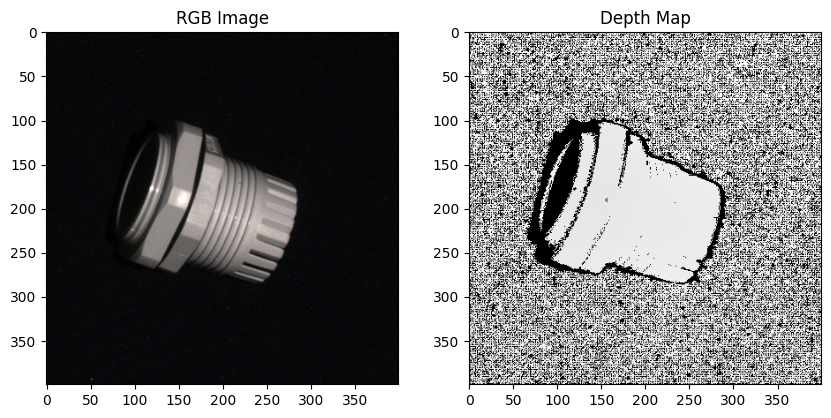

In [8]:
# Root directory and category
root = 'datasets/MVTec3D'
category = 'cable_gland'

# Create an instance of the dataset
config = Config()
dataset = Dataset_maker(root, category, config, is_train=True)

# Visualize a sample depth map
index = 0  # Change this to visualize different samples
image_4ch, label = dataset[index]

# Separate the RGB image and depth map
rgb_image = image_4ch[:3]
depth_map = image_4ch[3]

# Convert tensors to numpy arrays for visualization
rgb_image_np = rgb_image.permute(1, 2, 0).numpy()
depth_map_np = depth_map.squeeze().numpy()

# Plot the images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('RGB Image')
plt.imshow((rgb_image_np + 1) / 2)  # Convert back to [0, 1] range

plt.subplot(1, 2, 2)
plt.title('Depth Map')
plt.imshow(depth_map_np, cmap='gray')

plt.show()